In [49]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=2)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# 1. Create data structures with IDs and target values

# Which examples belong to test set?

f = open('INDEX_core_data.2013','r')
testset = {}

for line in f:
    if not(line.startswith('#')): # skip info lines
        parts = line.split()
        id = parts[0]
        testset[id] = 1 # to know which examples belong to test set
f.close()

# Make ID file of example and keep index to know which examples are in training and test set

f = open('INDEX_refined_data.2015','r')
o1 = open('pdbbind2015_ids','w')

count = 0
index = {}
value = {}

for line in f:
    if not(line.startswith('#')): # skip info lines
        parts = line.split()
        id = parts[0]
        val = parts[3]
        o1.write(id+' '+val+'\n')
        index[id] = count
        value[id] = val
        count += 1

f.close()
o1.close()

o2 = open('pdbbind2015.train','w')
o3 = open('pdbbind2015.test','w')

for k in index.keys():
    if k in testset.keys():
        o3.write(str(value[k])+' '+str(index[k])+'\n')
    else:
        o2.write(str(value[k])+' '+str(index[k])+'\n')

o2.close()
o3.close()

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin
import os, sys
import networkx as nx

# for adjacency functions
import math
    
import logging
logger = logging.getLogger(__name__)


class ConvertProteinLigand(BaseEstimator, TransformerMixin):

    #def __init__(self, ligand_file, protein_file, max_depth=10, attribute='active', key_nesting='nesting'):
        #self.ligand_file = ligand_file
        #self.protein_file = protein_file
        #self.max_depth = max_depth
        #self.attribute = attribute
        #self.key_nesting = key_nesting
        
    def __init__(self, dist=4):
        self.dist = dist
    
    def fit(self):
        return self

    def transform(self, id_file):
        #try:
        #    dirs = os.listdir(path)
        #    for file_name in dirs:
        #        if '.graph' in file_name:
        #            graph = self.load_interaction_graph(os.path.join(path, file_name))
        #            if graph.nodes():
        #                yield graph
        #except Exception as e:
        #    logger.debug('Failed iteration. Reason: %s' % e)
        #    logger.debug('Exception', exc_info=True)
        f = open(id_file,'r')
        for line in f:
            line = line.rstrip('\n')
            parts = line.split(' ')
            
            id = parts[0]
            target = parts[1]
            
            directory = 'atomCombined'
            if not os.path.exists(directory):
                os.makedirs(directory)

            ligand_file = 'refined-2015/'+id+'/'+id+'_ligand.mol2'
            pocket_file = 'refined-2015/'+id+'/'+id+'_pocket.pdb'
            combined_file = 'atomCombined/'+id+'_combined.txt'
            
            self.write_to_combined_file(id, ligand_file, pocket_file, combined_file)
            
            graph = self.load_interaction_graph(id, target, self.dist, combined_file)
            if graph.nodes():
                yield graph
        f.close()
    
    def _parse_protein_name(self, name): # DEPRECATED (to remove)
        #interaction_data/interaction6840_5STD.graph
        tokens = name.split('.')
        # remove .graph
        name = tokens[0]
        # remove first part
        tokens = name.split('/')
        name = tokens[1]
        tokens = name.split('_')
        name = tokens[1]
        name = name.lower()
        return name

    # Returns a tuple with 3D coordinates form a given line
    def extractXYZ(self, line):
        ar = line.split(":")[:3]
        return (float(ar[0]), float(ar[1]), float(ar[2]))

    # Return the squared distance between two points in 3D space
    def distance(self, p1, p2):
        return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2

    # Adds point to the adjacency vector of another point
    def addToAdjacency(self, id1, id2, dist, adl):
        val2 = str(id2) + '-' + str(dist)
        if id1 not in adl:
            adl[id1] = [val2]
        else:
            adl[id1].append(val2)
        
        val1 = str(id1) + '-' + str(dist)
        if id2 not in adl:
            adl[id2] = [val1]
        else:
            adl[id2].append(val1)

    # Computes the adjacent point for every point in the example        
    def extractAdjacency(self, file, dist):
        # TODO: create list of strings instead of writing to files (more efficient)
    
        f = open(file,'r')
        d = float(dist)**2
        lst = []
        # get all the atoms
        for line in f:
            lst.append(self.extractXYZ(line))
        f.close()

        adj = {}
        for id1 in range(len(lst)):
            for id2 in range(id1+1, len(lst)):
                p1 = lst[id1]
                p2 = lst[id2]

                distance_p1p2 = self.distance(p1,p2)
                if (distance_p1p2 == 0):
                    print 'In file '+file+' at '+str(p1)+' and '+str(p2)+' distance is 0'
                    # hack (just use a small distance)
                    distance_p1p2 = 0.01
                if distance_p1p2 < d:
                    dist_sq = round(np.sqrt(distance_p1p2), 3)
                    self.addToAdjacency(id1, id2, dist_sq, adj)

        adj_lines = []
        for id1 in range(len(lst)):
            adj_line = str(id1+1) + ":"
            if id1 in adj:
                for id2 in adj[id1]:
                    #f_out.write(str(id2+1)+",") we 
                    parts = id2.split('-')
                    print_id = int(parts[0]) + 1
                    print_dist = parts[1]
                    adj_line = adj_line + str(print_id)+"-"+str(print_dist)+","
            adj_lines.append(adj_line)
        return adj_lines
    
    
    def write_to_combined_file(self, id, ligand_file, pocket_file, combined_file):
        combinedfile_out = open(combined_file,'w')

        # retrieve ligand and parse (MOL2 format)
        ligand_stream = open(ligand_file,'r')

        # 1 N         -27.4310  -20.9950  -15.7020 N.4       1 MLY         0.2327
        l = ligand_stream.readline()
        while (l != ''):
            if (l.startswith('@<TRIPOS>ATOM')):
                l = ligand_stream.readline()
                while (not l.startswith('@<TRIPOS>BOND')):
                    l = l.rstrip('\n')
                    parts = l.split()
                    # TODO: do extra check here to see if parts are valid? (check if 5th part is a letter for example?)
                    xco = parts[2]
                    yco = parts[3]
                    zco = parts[4]
                    atomtype_raw = parts[5]
                    atomtype_parts = atomtype_raw.split('.')
                    atomtype = atomtype_parts[0]
                    combinedfile_out.write(xco+':'+yco+':'+zco+':'+atomtype+':ligand\n')
                    l = ligand_stream.readline()
            l = ligand_stream.readline()

        ligand_stream.close()
    
        # retrieve protein and parse (PDB format)
        pocket_stream = open(pocket_file,'r')

        for al in pocket_stream:
            if (al.startswith('ATOM')):
                al_list = list(al)
                xco = al_list[30:38]
                yco = al_list[38:46]
                zco = al_list[46:54]
                atomtype = al_list[76:78]
                xco = (''.join(xco)).strip()
                yco = (''.join(yco)).strip()
                zco = (''.join(zco)).strip()
                atomtype = (''.join(atomtype)).strip()
                combinedfile_out.write(xco+':'+yco+':'+zco+':'+atomtype+':protein\n')
        pocket_stream.close()

        combinedfile_out.close()
    
    def load_interaction_graph(self, id, target, dist, atom_file):
       
        # make graph object
        graph = nx.Graph()
        graph.graph['id'] = id
        graph.graph['target'] = float(target)

        # process nodes

        count = 1

        atom_stream = open(atom_file,'r')

        for atom_line in atom_stream:
            if (atom_line != ''):
                atom_line = atom_line.rstrip('\n')
                parts = atom_line.split(':')
                xco = parts[0]
                yco = parts[1]
                zco = parts[2]
                atomtype = parts[3]
                origin = parts[4] # ligand or protein

                graph.add_node(count, label=atomtype, type=origin)

                count += 1

        atom_stream.close()

        # process edges
        # node ids start from 1 in adj files
    
        l = '1' # just put one for now as label

        adj_lines = self.extractAdjacency(atom_file, dist)
        #adj_stream = open(adj_file,'r')
        for adj_line in adj_lines:
            parts = adj_line.split(':')
            kn1 = parts[0]
            neighbors = parts[1].split(',')
            for kn2 in neighbors:
                if (kn2 != ''):
                    kn2_parts = kn2.split('-')
                    kn2_id = kn2_parts[0]
                    kn2_dist = float(kn2_parts[1])
                    if (kn1 < kn2_id):
                        if graph.node[int(kn1)]['type'] != graph.node[int(kn2_id)]['type']: # they have a different type (ligand/protein)
                            graph.add_edge(int(kn1),int(kn2_id),label='protein_ligand',distance=kn2_dist,weight=1/kn2_dist,nesting=True)
                        else:
                            graph.add_edge(int(kn1),int(kn2_id),label='internal_bond',distance=kn2_dist,weight=1/kn2_dist)
                    #else:
                    #    if graph.node[int(kn1)]['type'] != graph.node[int(kn2_id)]['type']: # they have a different type (ligand/protein)
                    #        graph.add_edge(int(kn2_id),int(kn1),label='protein_ligand',distance=kn2_dist,weight=1/distance,nesting=True)
                    #    else:
                    #        graph.add_edge(int(kn2_id),int(kn1),label='internal_bond',distance=kn2_dist,weight=1/kn2_dist)

        #adj_stream.close()

        return graph

In [52]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
##import mpld3
##from mpld3 import plugins, utils
#mpld3.enable_notebook()

In [53]:
from collections import defaultdict, deque
class MarkActive(BaseEstimator, TransformerMixin):

    """
    Missing.
    """

    def __init__(self, max_depth=10, attribute='active', key_nesting='nesting'):
        self.max_depth = max_depth
        self.attribute = attribute
        self.key_nesting = key_nesting

    def fit(self):
        return self

    def transform(self, graphs):
        """
        Todo.
        """
        try:
            for graph in graphs:
                marked_graph = self.mark_active(graph)
                yield marked_graph
        except Exception as e:
            logger.debug('Failed iteration. Reason: %s' % e)
            logger.debug('Exception', exc_info=True)

    def mark_active(self, graph):
        for u,v in graph.edges():
            # iterate over edges and select edges that are of the nesting type
            if graph.edge[u][v].get(self.key_nesting,False):
                # selct the smallest id node as root for marking
                if u < v:
                    root=u
                else:
                    root=v
                self.mark_single_vertex_breadth_first_visit(graph, root=root)
        return graph
            
    def mark_single_vertex_breadth_first_visit(self, graph, root=None):
        visited = set()  # use a set as we can end up exploring few nodes
        # q is the queue containing the frontieer to be expanded in the BFV
        q = deque()
        q.append(root)
        # the map associates to each vertex id the distance from the root
        dist = {}
        dist[root] = 0
        visited.add(root)
        while len(q) > 0:
            # extract the current vertex
            u = q.popleft()
            d = dist[u] + 1
            if d <= self.max_depth:
                # iterate over the neighbors of the current vertex
                for v in graph.neighbors(u):
                    if v not in visited:
                        # skip nesting edge-nodes
                        if graph.edge[u][v].get(self.key_nesting, False) is False:
                            dist[v] = d
                            visited.add(v)
                            graph.node[v][self.attribute]=True
                            q.append(v)

In [54]:
#def make_target(target_fname, graphs):
#    target = dict()
#    with open(target_fname) as f:
#        for line in f:
#            line = line.strip()
#            tokens = line.split()
#            target[tokens[0]] = tokens[1]
#    # extract y
#    y = [float(target[graph.graph['id']]) for graph in graphs]
#    # TODO: make dictionary of targets based on input file
#    #graph.graph[‘target’]=y[id]
#    import numpy as np
#    y = np.array(y)
#    return y

In [55]:
def plot(y,predicted):
    size=9
    fig = plt.figure(figsize=(size, size)) 
    plt.hexbin(y, predicted, bins='log', gridsize=15, cmap='autumn')
    plt.scatter(y, predicted, s=2)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.grid()
    plt.show()

# Experiment

In [56]:
from GArDen.interfaces import convert, transform

In [57]:
graphs = convert('pdbbind2015_ids', program=ConvertProteinLigand(dist=4))

In [58]:
%%time
graphs_subset=list(islice(graphs,300))

In file atomCombined/4bps_combined.txt at (60.873, 9.889, 13.392) and (60.873, 9.889, 13.392) distance is 0
In file atomCombined/4bps_combined.txt at (61.146, 10.892, 13.407) and (61.146, 10.892, 13.407) distance is 0
In file atomCombined/4bps_combined.txt at (61.101, 9.3, 12.566) and (61.101, 9.3, 12.566) distance is 0
CPU times: user 37.4 s, sys: 739 ms, total: 38.1 s
Wall time: 39.4 s


In [14]:
#from eden.converter.graph.node_link_data import eden_to_node_link_data

#lines = eden_to_node_link_data(graphs)
#for line in lines:
#    print line
    
#from eden.util import display
#print display.serialize_graph(graphs.next())

/Users/leander/anaconda/envs/eden_env/lib/python2.7/site-packages/pygraphviz/agraph.py:1338: RuntimeWarning: Error: remove_overlap: Graphviz not built with triangulation library

  warnings.warn(b"".join(errors), RuntimeWarning)


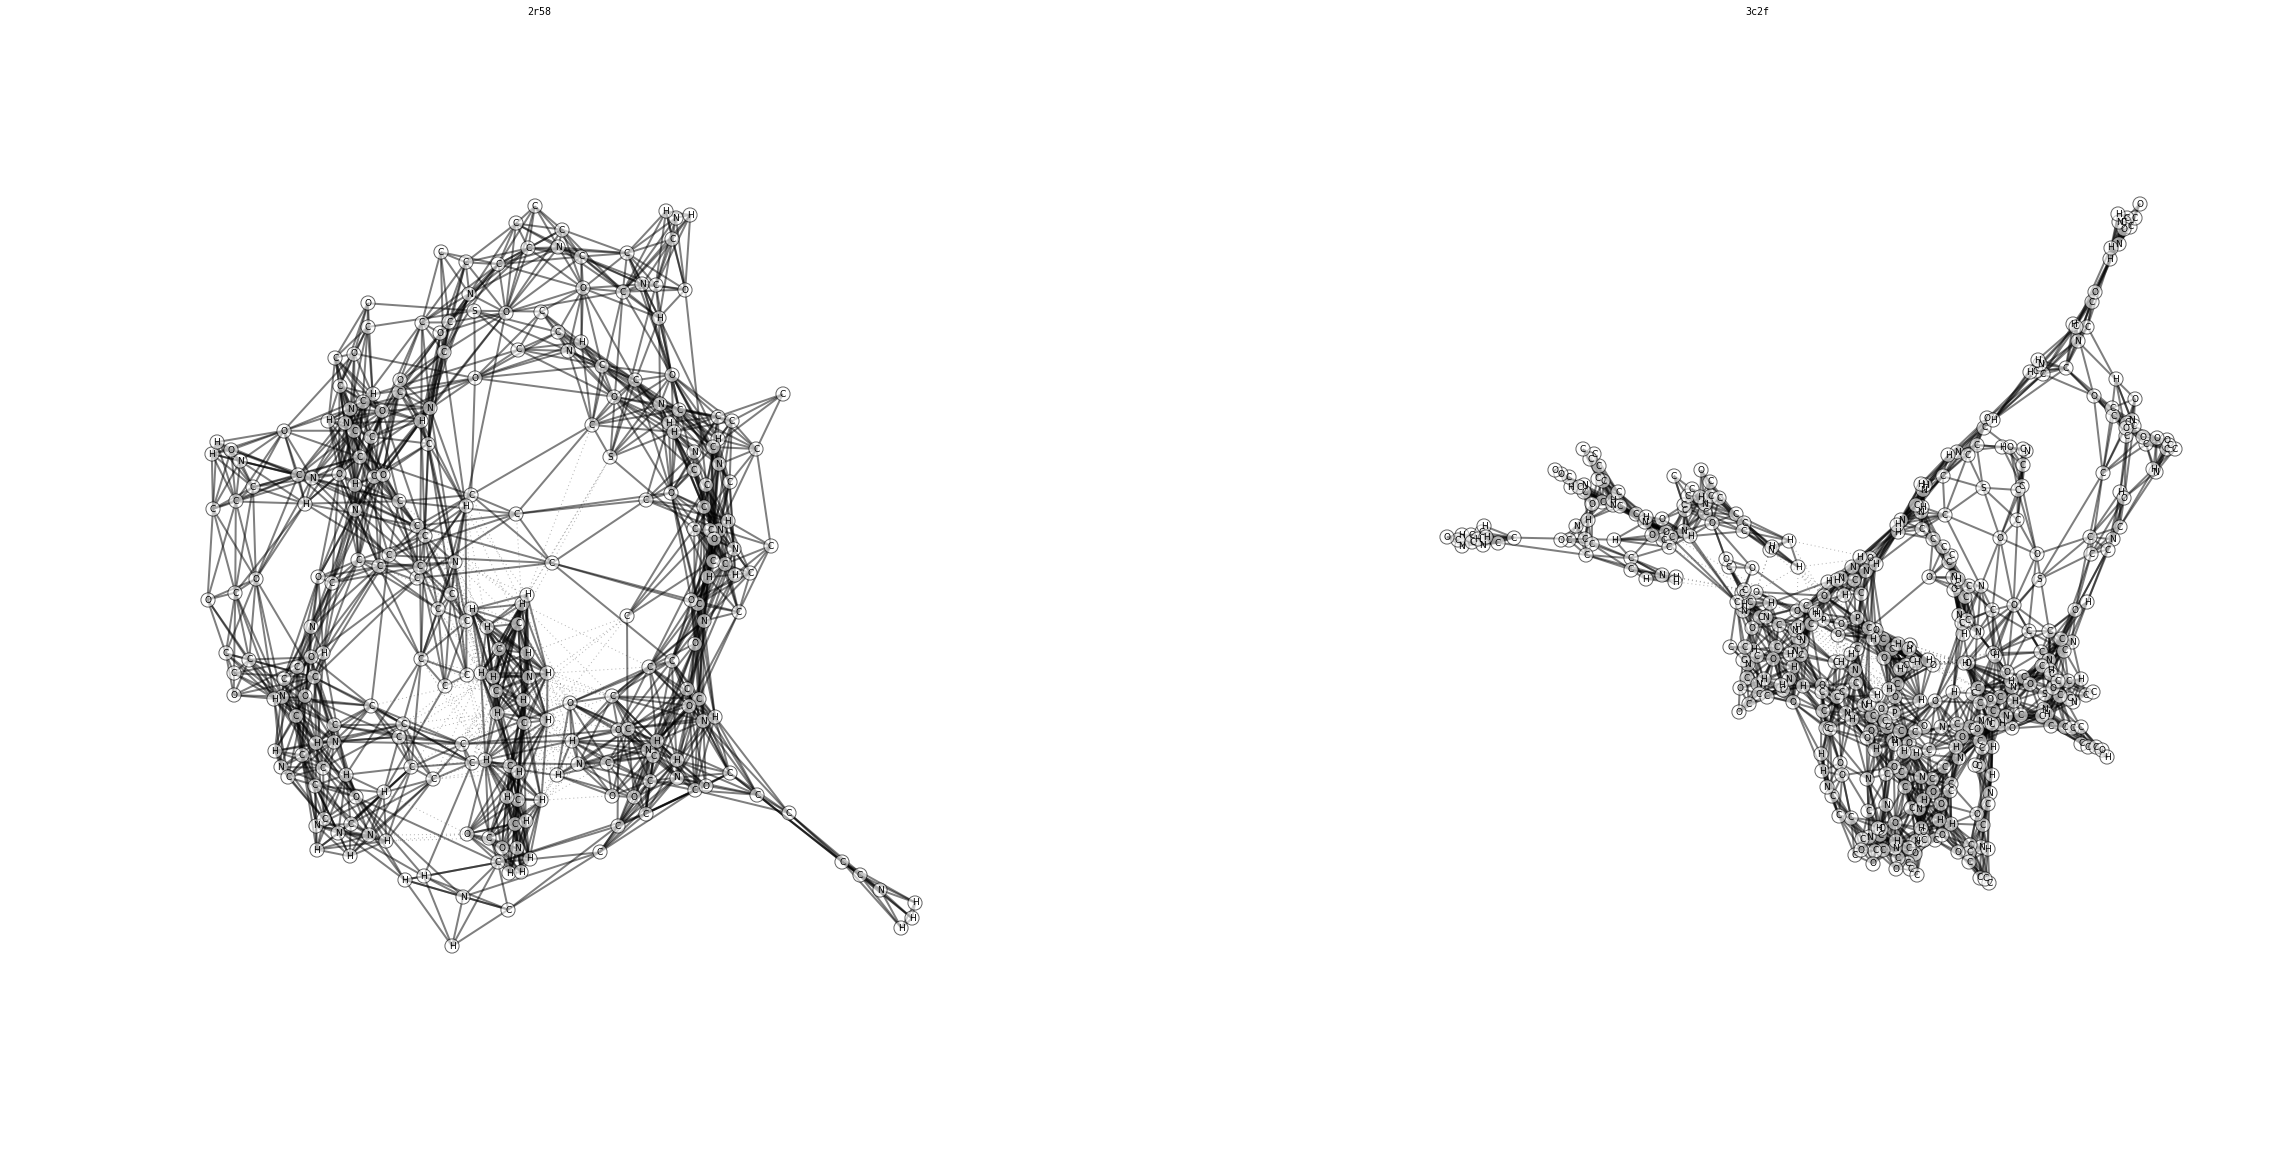

In [15]:
from itertools import islice
from eden.util.display import draw_graph_set
#draw_graph_set(islice(graphs,2), n_graphs_per_line=2, size=20, title_key='id', prog='sfdp', node_border=1, node_size=200, colormap='Set3',
#               edge_color='_label_',vertex_alpha=1, edge_alpha=.4, vertex_label='label', #secondary_vertex_label='type', 
#               vertex_color='level', ignore_for_layout='nesting')
draw_graph_set(islice(graphs,2), n_graphs_per_line=2, size=20, prog='sfdp', node_border=1, node_size=200, colormap='Set3') #secondary_vertex_label='type', 

In [16]:
#from GArDen.transform.node import AddNodeAttributeValue
#parameters_priors = dict(attribute='active', value=False)
#graphs = transform(graphs, program=AddNodeAttributeValue(), parameters_priors=parameters_priors)

In [59]:
class DeleteEdgeGreaterThan(BaseEstimator, TransformerMixin):
    """
    Delete edges.

    Delete an edge if its dictionary has a key equal to 'attribute' and
    the 'condition' is true between 'value' and the value associated to
    key=attribute.
    """

    def __init__(self, attribute=None, value=None):
        """Constructor."""
        self.attribute = attribute
        self.value = value

    def transform(self, graphs):
        """Transform."""
        try:
            for graph in graphs:
                graph = self._delete_edges(graph)
                yield graph
        except Exception as e:
            logger.debug('Failed iteration. Reason: %s' % e)
            logger.debug('Exception', exc_info=True)

    def _delete_edges(self, graph):
        for u, v in graph.edges():
            if self.attribute in graph.edge[u][v] and \
                    graph.edge[u][v].get(self.attribute, False) >= self.value:
                graph.remove_edge(u, v)
        return graph


In [18]:
#from GArDen.transform import DeleteNode
#parameters_priors = dict(attribute_value_dict=[dict(active=False, type='protein')])
#graphs_subset = transform(graphs_subset, program=DeleteEdgeGreaterThan(attribute='distance',value=3))

In [19]:
from itertools import islice
from eden.util.display import draw_graph_set
#draw_graph_set(islice(graphs,2), n_graphs_per_line=2, size=20, title_key='id', prog='sfdp', node_border=1, node_size=200, colormap='Set3',
#               edge_color='_label_',vertex_alpha=1, edge_alpha=.4, vertex_label='label', #secondary_vertex_label='type', 
#               vertex_color='level', ignore_for_layout='nesting')
draw_graph_set(islice(graphs_subset,4), n_graphs_per_line=2, size=20, prog='sfdp', node_border=1, node_size=200, colormap='Set3') #secondary_vertex_label='type', 

NameError: name 'graphs_subset' is not defined

In [22]:
#parameters_priors = dict(max_depth=3, attribute='active')
#graphs = transform(graphs, program=MarkActive(), parameters_priors=parameters_priors)

In [23]:
#from GArDen.transform import DeleteNode
#parameters_priors = dict(attribute_value_dict=[dict(active=False, type='protein')])
#graphs = transform(graphs, program=DeleteNode(), parameters_priors=parameters_priors)

In [60]:
from GArDen.transform.trim_to_largest_component import TrimToLargestComponent
graphs_subset = transform(graphs_subset, program=TrimToLargestComponent())
#graphs = transform(graphs, program=TrimToLargestComponent())

In [25]:
#%%time
#graphs=list(graphs)

In [ ]:
from itertools import islice
from eden.util.display import draw_graph_set
from GArDen.transform.node import ColorNode
parameters_priors = dict(output_attribute='level', labels=[['C','O','N','S','H','Cl','.C','.O','.N','.S','.H','.Cl']])
draw_graphs = transform(islice(graphs_subset,8), program=ColorNode(), parameters_priors=parameters_priors)
draw_graph_set(draw_graphs, n_graphs_per_line=2, size=20, title_key='id', prog='sfdp', node_border=1, node_size=200, colormap='Set3',
               edge_color='_label_',vertex_alpha=1, edge_alpha=.4, vertex_label='label', #secondary_vertex_label='type', 
               vertex_color='level', ignore_for_layout='nesting')

---

# Predictive modeling

In [ ]:
# read a target map 
#target_fname = 'PDBbind_refined07-core07.txt'
#y = make_target(target_fname, graphs)

In [37]:
y = np.array([ g.graph['target'] for g in graphs ])
print y

In file atomCombined/4bps_combined.txt at (60.873, 9.889, 13.392) and (60.873, 9.889, 13.392) distance is 0
In file atomCombined/4bps_combined.txt at (61.146, 10.892, 13.407) and (61.146, 10.892, 13.407) distance is 0
In file atomCombined/4bps_combined.txt at (61.101, 9.3, 12.566) and (61.101, 9.3, 12.566) distance is 0
[  2.     2.     2.   ...,  11.82  11.85  11.92]


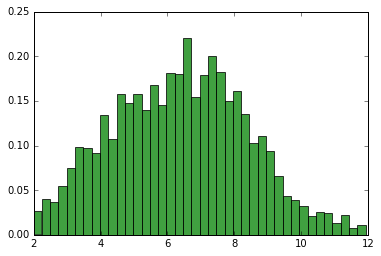

In [38]:
plt.hist(y, 40, normed=1, facecolor='green', alpha=0.75)
plt.show()

In [1]:
# Make separate training and test set

%%time
from eden.graph import Vectorizer
from eden.util import vectorize

training_graphs = [ g for g in graphs if g.graph['id'] not in testset.keys() ]
test_graphs = [ g for g in graphs if g.graph['id'] in testset.keys() ]

X_train = vectorize(training_graphs, vectorizer=Vectorizer(complexity=2), fit_flag=False, n_jobs=-1)
X_test = vectorize(test_graphs, vectorizer=Vectorizer(complexity=2), fit_flag=False, n_jobs=-1)


SyntaxError: invalid syntax (<ipython-input-1-c3ec20da5745>, line 3)

In [2]:
y_train = np.array([ g.graph['target'] for g in graphs_subset ])# if g.graph['id'] not in testset.keys()])
print y_train

y_test = np.array([ g.graph['target'] for g in graphs_subset if g.graph['id'] in testset.keys()])
#print y_test

plt.hist(y_train, 40, normed=1, facecolor='green', alpha=0.75)
plt.show()

NameError: name 'np' is not defined

In [39]:
%%time
from eden.graph import Vectorizer
from eden.util import vectorize
X = vectorize(graphs, vectorizer=Vectorizer(complexity=2), fit_flag=False, n_jobs=-1)
print 'Instances: %d Features: %d with an avg of %d features per instance' % (X.shape[0], X.shape[1],  X.getnnz()/X.shape[0])

Exception: ERROR: something went wrong:                no graphs are present in current iterator.

In [30]:
%%time
import time
#induce a predictive model
from sklearn.svm import SVR
predictor = SVR(C=62.52,gamma=0.279)

from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_predict
#predicted = cross_val_predict(predictor, X, y, cv=5, n_jobs=-1)
predicted = cross_val_predict(predictor, X, y, cv=StratifiedKFold(y, n_folds=5, shuffle=True, random_state=int(time.time())), n_jobs=-1)

print 'Corr coeff: %.4f'%(np.corrcoef([predicted,y])[0][1])

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Corr coeff: 0.6521
CPU times: user 248 ms, sys: 181 ms, total: 428 ms
Wall time: 9.26 s


In [19]:
%%time
import time
#induce a predictive model
from sklearn.svm import SVR
predictor = SVR(C=62.52,gamma=0.279)

from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_predict
#predicted = cross_val_predict(predictor, X, y, cv=5, n_jobs=-1)
predicted = cross_val_predict(predictor, X, y, cv=StratifiedKFold(y, n_folds=5, shuffle=True, random_state=int(time.time())), n_jobs=-1)

print 'Corr coeff: %.4f'%(np.corrcoef([predicted,y])[0][1])

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Corr coeff: 0.6428
CPU times: user 267 ms, sys: 316 ms, total: 583 ms
Wall time: 7.4 s


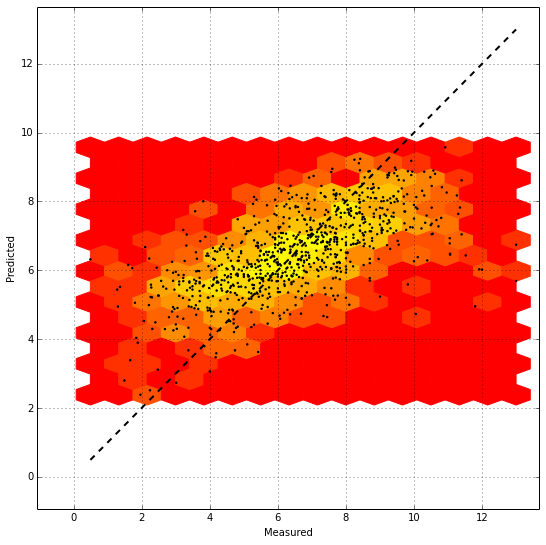

In [20]:
plot(y,predicted)

---

# Range experiment

In [32]:
from GArDen.interfaces import convert, transform
from GArDen.transform.node import AddNodeAttributeValue
from GArDen.transform import DeleteNode
from GArDen.transform.trim_to_largest_component import TrimToLargestComponent
from eden.graph import Vectorizer
from eden.util import vectorize
from sklearn.svm import SVR
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import StratifiedKFold
import time

def run_experiment(data_fname='interaction_data', 
                   target_fname = 'PDBbind_refined07-core07.txt', 
                   max_depth=1, 
                   complexity=5,
                   C=100,
                   gamma=0.1,
                   n_iter=5):    
    graphs = convert(data_fname, program=ConvertProteinLigand())
    parameters_priors = dict(attribute='active', value=False)
    graphs = transform(graphs, program=AddNodeAttributeValue(), parameters_priors=parameters_priors)
    parameters_priors = dict(max_depth=max_depth, attribute='active')
    graphs = transform(graphs, program=MarkActive(), parameters_priors=parameters_priors)
    parameters_priors = dict(attribute_value_dict=[dict(active=False, type='protein')])
    graphs = transform(graphs, program=DeleteNode(), parameters_priors=parameters_priors)
    graphs = transform(graphs, program=TrimToLargestComponent())
    graphs = list(graphs)
    X = vectorize(graphs, vectorizer=Vectorizer(complexity=complexity), fit_flag=False, n_jobs=-1)
    y = make_target(target_fname, graphs)
    
    corr_list=[]
    for i in range(n_iter):
        predictor = SVR(C=C, gamma=gamma)
        predicted = cross_val_predict(predictor, X, y, cv=StratifiedKFold(y, n_folds=5, shuffle=True, random_state=int(time.time())), n_jobs=-1)
        corr = np.corrcoef([predicted,y])[0][1]
        corr_list.append(corr)
    return np.mean(corr_list), np.std(corr_list)

In [ ]:
%%time
import time
import datetime
x1 = []
x2 = []
x3 = []
for max_depth in range(10):
    start = time.time()
    corr_mean, corr_std = run_experiment(data_fname='interaction_data', target_fname = 'PDBbind_refined07-core07.txt', 
                                         max_depth=max_depth,
                                         complexity=2,
                                         C=62.52,
                                         gamma=0.279, 
                                         n_iter=20)
    
    delta_time = datetime.timedelta(seconds=(time.time() - start))
    print 'Max depth: %d   Corr coeff: %.3f +- %.3f   in: %s' % (max_depth, corr_mean, corr_std, str(delta_time))
    x1.append(corr_mean)
    x3.append(corr_std)
    x2.append(max_depth)
x1=np.array(x1)
x2=np.array(x2)
x3=np.array(x3)

Max depth: 0   Corr coeff: 0.649 +- 0.011   in: 0:01:20.988471


In [ ]:
size=7
fig = plt.figure(figsize=(int(2*size), size)) 
plt.fill_between(x2, x1+2*x3, x1-2*x3, facecolor='blue', alpha=0.2)
plt.fill_between(x2, x1+x3, x1-x3, facecolor='blue', alpha=0.2)
plt.plot(x2, x1,  ls='-', lw=2,  marker='o', ms=10, color='k', mew=2, mfc='white')
plt.xlabel('Max depth')
plt.ylabel('Corr coeff')
plt.grid()
plt.xlim(np.min(x2)-.1,np.max(x2)+.1)
plt.show()

In [24]:
%%time
import time
import datetime
x1 = []
x2 = []
x3 = []
for max_depth in range(10):
    start = time.time()
    corr_mean, corr_std = run_experiment(data_fname='interaction_data', target_fname = 'PDBbind_refined07-core07.txt', 
                                         max_depth=max_depth,
                                         complexity=2,
                                         C=62.52,
                                         gamma=0.279, 
                                         n_iter=20)
    
    delta_time = datetime.timedelta(seconds=(time.time() - start))
    print 'Max depth: %d   Corr coeff: %.3f +- %.3f   in: %s' % (max_depth, corr_mean, corr_std, str(delta_time))
    x1.append(corr_mean)
    x3.append(corr_std)
    x2.append(max_depth)
x1=np.array(x1)
x2=np.array(x2)
x3=np.array(x3)

Max depth: 0   Corr coeff: 0.648 +- 0.010   in: 0:12:01.571589
Max depth: 1   Corr coeff: 0.625 +- 0.007   in: 0:02:17.514675
Max depth: 2   Corr coeff: 0.653 +- 0.007   in: 0:02:41.356463
Max depth: 3   Corr coeff: 0.657 +- 0.008   in: 0:02:58.578843
Max depth: 4   Corr coeff: 0.656 +- 0.007   in: 0:03:17.912149
Max depth: 5   Corr coeff: 0.653 +- 0.006   in: 0:03:33.131342
Max depth: 6   Corr coeff: 0.650 +- 0.007   in: 0:03:50.709962
Max depth: 7   Corr coeff: 0.641 +- 0.007   in: 0:04:02.840616
Max depth: 8   Corr coeff: 0.640 +- 0.008   in: 0:04:20.989106
Max depth: 9   Corr coeff: 0.642 +- 0.008   in: 0:04:31.479377
CPU times: user 10min 12s, sys: 47.4 s, total: 11min
Wall time: 43min 36s


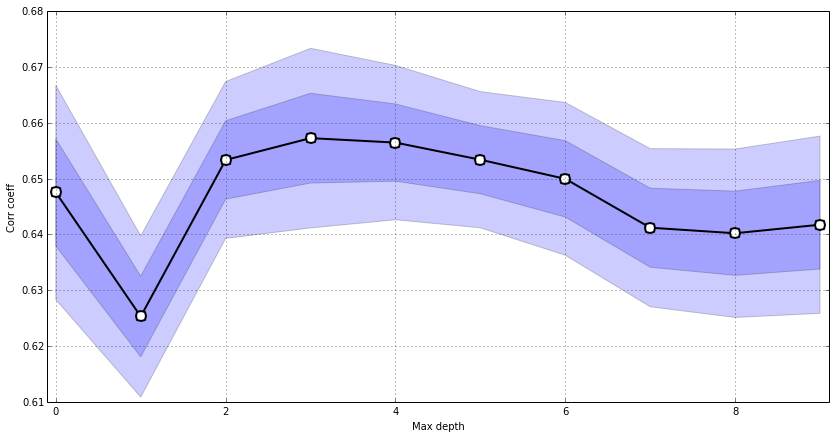

In [32]:
size=7
fig = plt.figure(figsize=(int(2*size), size)) 
plt.fill_between(x2, x1+2*x3, x1-2*x3, facecolor='blue', alpha=0.2)
plt.fill_between(x2, x1+x3, x1-x3, facecolor='blue', alpha=0.2)
plt.plot(x2, x1,  ls='-', lw=2,  marker='o', ms=10, color='k', mew=2, mfc='white')
plt.xlabel('Max depth')
plt.ylabel('Corr coeff')
plt.grid()
plt.xlim(np.min(x2)-.1,np.max(x2)+.1)
plt.show()

---